In [171]:
import chardet
import unicodedata

import pandas as pd
import os
import json
from datetime import datetime
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

In [172]:
def add_time_data(df, time_column, extra_col_name = ""):
    """transforms time column into datetime format and adds day, month, year, and hour columns.
    In case there is more than one time column in the dataframe you can extend the name of the
    new variables by using the extra_col_name variable"""
    df[time_column] = pd.to_datetime(df[time_column])
    df[extra_col_name + "day"] = df.apply(lambda row: row[time_column].day, axis = 1)
    df[extra_col_name + "month"] = df.apply(lambda row: row[time_column].month, axis = 1)
    df[extra_col_name + "year"] = df.apply(lambda row: row[time_column].year, axis = 1)
    df[extra_col_name + "hour"] = df.apply(lambda row: row[time_column].hour, axis = 1)

    return df

def basic_df_load_and_clean(data_folder, data_file_name, sep = None):
    #this 2 lines allow to retrieve the encoding so that we can open the file
    with open(os.path.join(data_folder, data_file_name), 'rb') as f:
        result = chardet.detect(f.read())

    df = pd.read_csv(os.path.join(data_folder, data_file_name), sep=sep,encoding=result['encoding'])

    # define a helper function to remove accents from text
    def remove_accents(text):
        return ''.join(c for c in unicodedata.normalize('NFD', text) if unicodedata.category(c) != 'Mn')

    #setting all column names into lowercase without accents
    # get the current column names
    old_column_names = df.columns.tolist()

    # remove accents and set to lowercase for each column name
    new_column_names = [remove_accents(name).lower() for name in old_column_names]

    # use the new column names to rename the columns
    df = df.rename(columns=dict(zip(old_column_names, new_column_names)))

    # drop rows that have all Nans
    df = df.dropna(how="all")

    return df

## Loading data

In [173]:
data_basepath = "../storage/raw"

hist_events_path = "general_info/calendario.csv"
hist_weather_stations_path = "historical_data/202105_merged_weather_trips_stations.csv"

hist_events_df = basic_df_load_and_clean(data_basepath, hist_events_path)
hist_weather_stations_df = basic_df_load_and_clean(data_basepath, hist_weather_stations_path)

/var/folders/yw/h9ndkfbx6_lb6gwchxbgts2m0000gn/T/ipykernel_77825/3458862075.py:18: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support sep=None with delim_whitespace=False; you can avoid this warning by specifying engine='python'.
  df = pd.read_csv(os.path.join(data_folder, data_file_name), sep=sep,encoding=result['encoding'])
/var/folders/yw/h9ndkfbx6_lb6gwchxbgts2m0000gn/T/ipykernel_77825/3458862075.py:18: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support sep=None with delim_whitespace=False; you can avoid this warning by specifying engine='python'.
  df = pd.read_csv(os.path.join(data_folder, data_file_name), sep=sep,encoding=result['encoding'])


In [174]:
hist_events_df.head()

,dia,dia_semana,laborable / festivo / domingo festivo,tipo de festivo,festividad
0,01/01/2013,martes,festivo,Festivo nacional,Año Nuevo
1,02/01/2013,miercoles,laborable,NaN,NaN
2,03/01/2013,jueves,laborable,NaN,NaN
3,04/01/2013,viernes,laborable,NaN,NaN
4,05/01/2013,sabado,sabado,NaN,NaN


In [175]:
hist_events_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4016 entries, 0 to 4015
Data columns (total 5 columns):
 #   Column                                 Non-Null Count  Dtype 
---  ------                                 --------------  ----- 
 0   dia                                    4016 non-null   object
 1   dia_semana                             4016 non-null   object
 2   laborable / festivo / domingo festivo  2265 non-null   object
 3   tipo de festivo                        158 non-null    object
 4   festividad                             157 non-null    object
dtypes: object(5)
memory usage: 157.0+ KB


In [176]:
hist_weather_stations_df.head()

,activate,reservations_count,light,no_available,dock_bikes,total_bases,free_bases,id_station,longitude,latitude,...,hour,plugs_count,unplugs_count,81,82,83,86,87,88,89
0,1.0,0.0,2.0,0.0,14.0,30.0,13.0,1,-3.701834,40.417214,...,0,0.0,0.0,0.78,246.0,13.2,46.0,945.0,1.0,0.0
1,1.0,0.0,1.0,0.0,24.0,30.0,5.0,2,-3.701603,40.417313,...,0,0.0,0.0,0.78,246.0,13.2,46.0,945.0,0.0,0.0
2,1.0,0.0,0.0,0.0,5.0,24.0,17.0,3,-3.705842,40.420589,...,0,0.0,0.0,0.78,246.0,13.2,46.0,945.0,0.0,0.0
3,1.0,0.0,2.0,0.0,11.0,18.0,6.0,4,-3.706917,40.430294,...,0,0.0,0.0,0.27,179.0,12.8,41.0,949.0,0.0,0.0
4,1.0,0.0,2.0,0.0,12.0,24.0,10.0,5,-3.702587,40.428552,...,0,0.0,0.0,0.27,179.0,14.1,41.0,949.0,0.0,0.0


## Preparing data for merging

Incorporar flags de festivos, huelgas de transporte y de epoca covid

In [177]:
# adding year, month, day columnus to events
hist_events_df = add_time_data(hist_events_df, "dia")
hist_events_df.head()

/var/folders/yw/h9ndkfbx6_lb6gwchxbgts2m0000gn/T/ipykernel_77825/3458862075.py:5: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  df[time_column] = pd.to_datetime(df[time_column])


,dia,dia_semana,laborable / festivo / domingo festivo,tipo de festivo,festividad,day,month,year,hour
0,2013-01-01,martes,festivo,Festivo nacional,Año Nuevo,1,1,2013,0
1,2013-02-01,miercoles,laborable,NaN,NaN,1,2,2013,0
2,2013-03-01,jueves,laborable,NaN,NaN,1,3,2013,0
3,2013-04-01,viernes,laborable,NaN,NaN,1,4,2013,0
4,2013-05-01,sabado,sabado,NaN,NaN,1,5,2013,0


### Working days indicator

We will create a binary variable for working days, where 1 will be working day and 0 will be non working day, including festivities and weekends.

In [178]:
# creating binary column to flag non working days
hist_events_df["laborable / festivo / domingo festivo"].unique()

array(['festivo', 'laborable', 'sabado', 'domingo', nan, 'Festivo'],
      dtype=object)

"laborable / festivo / domingo festivo" should be nan never. We will impute this values as "laborable" for all days except "sabado" and "domingo"

In [179]:
hist_events_df[hist_events_df["laborable / festivo / domingo festivo"].isna()]

,dia,dia_semana,laborable / festivo / domingo festivo,tipo de festivo,festividad,day,month,year,hour
2197,2019-08-01,martes,NaN,NaN,NaN,1,8,2019,0
2198,2019-09-01,miercoles,NaN,NaN,NaN,1,9,2019,0
2199,2019-10-01,jueves,NaN,NaN,NaN,1,10,2019,0
2200,2019-11-01,viernes,NaN,NaN,NaN,1,11,2019,0
2201,2019-12-01,sabado,NaN,NaN,NaN,1,12,2019,0
...,...,...,...,...,...,...,...,...,...
4011,2023-12-27,miércoles,NaN,NaN,NaN,27,12,2023,0
4012,2023-12-28,jueves,NaN,NaN,NaN,28,12,2023,0
4013,2023-12-29,viernes,NaN,NaN,NaN,29,12,2023,0
4014,2023-12-30,sábado,NaN,NaN,NaN,30,12,2023,0


In [180]:
hist_events_df[hist_events_df["laborable / festivo / domingo festivo"].isna()].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1751 entries, 2197 to 4015
Data columns (total 9 columns):
 #   Column                                 Non-Null Count  Dtype         
---  ------                                 --------------  -----         
 0   dia                                    1751 non-null   datetime64[ns]
 1   dia_semana                             1751 non-null   object        
 2   laborable / festivo / domingo festivo  0 non-null      object        
 3   tipo de festivo                        0 non-null      object        
 4   festividad                             0 non-null      object        
 5   day                                    1751 non-null   int64         
 6   month                                  1751 non-null   int64         
 7   year                                   1751 non-null   int64         
 8   hour                                   1751 non-null   int64         
dtypes: datetime64[ns](1), int64(4), object(4)
memory usage: 136.8

Interestingly, we see that the missing values are uniformilly distributed

In [181]:
hist_events_df[hist_events_df["laborable / festivo / domingo festivo"].isna()].describe()

,day,month,year,hour
count,1751.000000,1751.000000,1751.000000,1751.0
mean,15.970303,6.555111,2021.005140,0.0
std,8.791829,3.439471,1.412385,0.0
min,1.000000,1.000000,2019.000000,0.0
25%,8.000000,4.000000,2020.000000,0.0
50%,16.000000,7.000000,2021.000000,0.0
75%,24.000000,10.000000,2022.000000,0.0
max,31.000000,12.000000,2023.000000,0.0


<AxesSubplot: xlabel='year', ylabel='Count'>

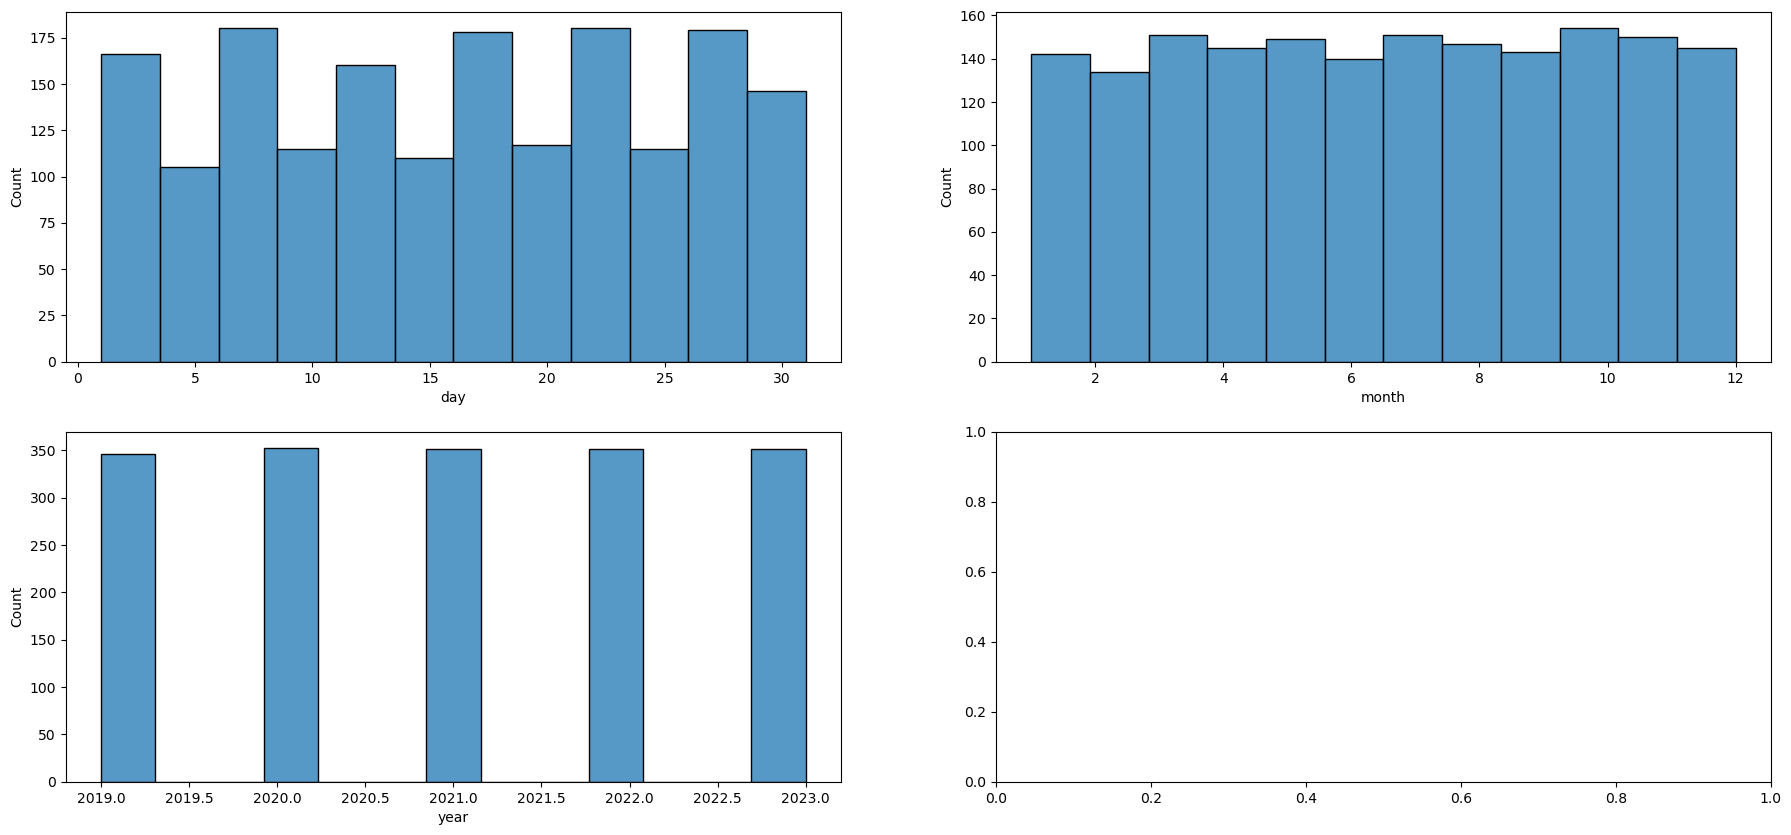

In [182]:
nrows = 2
ncols = 2

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(22, 10))

sns.histplot(data = hist_events_df.loc[hist_events_df["laborable / festivo / domingo festivo"].isna()], x = "day", ax = axes[0,0])
sns.histplot(data = hist_events_df.loc[hist_events_df["laborable / festivo / domingo festivo"].isna()], x = "month", ax = axes[0,1])
sns.histplot(data = hist_events_df.loc[hist_events_df["laborable / festivo / domingo festivo"].isna()], x = "year", ax = axes[1,0])


#axes[1,0] = hist_events_df.loc[hist_events_df["laborable / festivo / domingo festivo"].isna(), "year"].plot.hist(bins =10)

In [183]:
def input_day_type(day):
    if day == "sabado" or day =="domingo":
        out = day
    else:
        out = "laborable"
    return out

hist_events_df.loc[hist_events_df["laborable / festivo / domingo festivo"].isna(), "laborable / festivo / domingo festivo"] = hist_events_df.loc[hist_events_df["laborable / festivo / domingo festivo"].isna(), "laborable / festivo / domingo festivo"].apply(input_day_type)
hist_events_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4016 entries, 0 to 4015
Data columns (total 9 columns):
 #   Column                                 Non-Null Count  Dtype         
---  ------                                 --------------  -----         
 0   dia                                    4016 non-null   datetime64[ns]
 1   dia_semana                             4016 non-null   object        
 2   laborable / festivo / domingo festivo  4016 non-null   object        
 3   tipo de festivo                        158 non-null    object        
 4   festividad                             157 non-null    object        
 5   day                                    4016 non-null   int64         
 6   month                                  4016 non-null   int64         
 7   year                                   4016 non-null   int64         
 8   hour                                   4016 non-null   int64         
dtypes: datetime64[ns](1), int64(4), object(4)
memory usage: 282.5+ K

In [184]:
non_working_labels = ['festivo', 'sabado', 'domingo', 'Festivo']
hist_events_df["work_day_indicator"] = hist_events_df["laborable / festivo / domingo festivo"].apply(lambda value: 0 if value in non_working_labels else 1)

In [185]:
hist_events_df["work_day_indicator"].value_counts()

1    3243
0     773
Name: work_day_indicator, dtype: int64

In [186]:
hist_events_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4016 entries, 0 to 4015
Data columns (total 10 columns):
 #   Column                                 Non-Null Count  Dtype         
---  ------                                 --------------  -----         
 0   dia                                    4016 non-null   datetime64[ns]
 1   dia_semana                             4016 non-null   object        
 2   laborable / festivo / domingo festivo  4016 non-null   object        
 3   tipo de festivo                        158 non-null    object        
 4   festividad                             157 non-null    object        
 5   day                                    4016 non-null   int64         
 6   month                                  4016 non-null   int64         
 7   year                                   4016 non-null   int64         
 8   hour                                   4016 non-null   int64         
 9   work_day_indicator                     4016 non-null   int64   

In [187]:
hist_events_df.head()

,dia,dia_semana,laborable / festivo / domingo festivo,tipo de festivo,festividad,day,month,year,hour,work_day_indicator
0,2013-01-01,martes,festivo,Festivo nacional,Año Nuevo,1,1,2013,0,0
1,2013-02-01,miercoles,laborable,NaN,NaN,1,2,2013,0,1
2,2013-03-01,jueves,laborable,NaN,NaN,1,3,2013,0,1
3,2013-04-01,viernes,laborable,NaN,NaN,1,4,2013,0,1
4,2013-05-01,sabado,sabado,NaN,NaN,1,5,2013,0,0


### Adding covid indicator

- starting date lockdown: 15 march 2020.
- Duration: 43 days
- ending date: 27 april 2020

- days with restrictions: 83 (we won't use this info for the moment)

In [188]:
lock_down_starting_date = datetime(2020, 3, 15)
lock_down_ending_date = datetime(2020, 4, 27)

hist_events_df["covid_indicator"] = hist_events_df["dia"].apply(lambda value: 1 if value >= lock_down_starting_date and value < lock_down_ending_date else 0)

In [189]:
hist_events_df.head()

,dia,dia_semana,laborable / festivo / domingo festivo,tipo de festivo,festividad,day,month,year,hour,work_day_indicator,covid_indicator
0,2013-01-01,martes,festivo,Festivo nacional,Año Nuevo,1,1,2013,0,0,0
1,2013-02-01,miercoles,laborable,NaN,NaN,1,2,2013,0,1,0
2,2013-03-01,jueves,laborable,NaN,NaN,1,3,2013,0,1,0
3,2013-04-01,viernes,laborable,NaN,NaN,1,4,2013,0,1,0
4,2013-05-01,sabado,sabado,NaN,NaN,1,5,2013,0,0,0


In [190]:
hist_events_df["covid_indicator"].value_counts()

0    3973
1      43
Name: covid_indicator, dtype: int64

In [191]:
hist_events_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4016 entries, 0 to 4015
Data columns (total 11 columns):
 #   Column                                 Non-Null Count  Dtype         
---  ------                                 --------------  -----         
 0   dia                                    4016 non-null   datetime64[ns]
 1   dia_semana                             4016 non-null   object        
 2   laborable / festivo / domingo festivo  4016 non-null   object        
 3   tipo de festivo                        158 non-null    object        
 4   festividad                             157 non-null    object        
 5   day                                    4016 non-null   int64         
 6   month                                  4016 non-null   int64         
 7   year                                   4016 non-null   int64         
 8   hour                                   4016 non-null   int64         
 9   work_day_indicator                     4016 non-null   int64   

## Merge mechanism

In [192]:
hist_events_df_to_merge = hist_events_df[["dia_semana", "day", "month", "year", "work_day_indicator", "covid_indicator"]]
definitive_df = hist_weather_stations_df.merge(hist_events_df_to_merge, on = ["year", "month", "day"])
definitive_df.head()

,activate,reservations_count,light,no_available,dock_bikes,total_bases,free_bases,id_station,longitude,latitude,...,81,82,83,86,87,88,89,dia_semana,work_day_indicator,covid_indicator
0,1.0,0.0,2.0,0.0,14.0,30.0,13.0,1,-3.701834,40.417214,...,0.78,246.0,13.2,46.0,945.0,1.0,0.0,martes,1,0
1,1.0,0.0,1.0,0.0,24.0,30.0,5.0,2,-3.701603,40.417313,...,0.78,246.0,13.2,46.0,945.0,0.0,0.0,martes,1,0
2,1.0,0.0,0.0,0.0,5.0,24.0,17.0,3,-3.705842,40.420589,...,0.78,246.0,13.2,46.0,945.0,0.0,0.0,martes,1,0
3,1.0,0.0,2.0,0.0,11.0,18.0,6.0,4,-3.706917,40.430294,...,0.27,179.0,12.8,41.0,949.0,0.0,0.0,martes,1,0
4,1.0,0.0,2.0,0.0,12.0,24.0,10.0,5,-3.702587,40.428552,...,0.27,179.0,14.1,41.0,949.0,0.0,0.0,martes,1,0


### Saving dataframe

In [194]:
definitive_df.to_csv(os.path.join(data_basepath, "historical_data/202105_definitive.csv"),index=False)